# MODIS Water Raster Testing - Pre-trained Ensemble

Version: 0.1.0

Date modified: 02.08.2022

Modified by: Caleb Spradlin

In [1]:
import csv
import datetime
import glob
import joblib
import numpy as np
import os
import pandas as pd
from pathlib import Path
import sys

# Sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, f1_score
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.inspection import permutation_importance

# Tabnet
import torch
from pytorch_tabnet.tab_model import TabNetClassifier

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

#GDAL Stuff
from osgeo import gdalconst
from osgeo import gdal

from pprint import pprint
sys.path.append('../scripts/')
import notebook_util as nu

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
RASTER_OUTPUT_DIR = '/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output'

MODEL = 'ensemble_pretrained'
LABEL_NAME = 'water'
DATA_TYPE = np.int16
GPU = True

In [3]:
if GPU:
    nu.setup_one_gpu() # Choose the GPU with the lowest memory usage

Picking GPU 1


## Choose model weights

Choose how to weight the predictions from each pre-trained model.

In [4]:
MODEL_WEIGHTS = {'rf': 0.15, 'xgboost': 0.45,'tabnet': 0.40}

In [5]:
weights_tot = sum([w for w in MODEL_WEIGHTS.values()])
if weights_tot != 1.0:
    raise RuntimeError('Weights do not add up to 1')

In [6]:
rf_model_path = '/att/nobackup/cssprad1/projects/modis_water/models/mw_rf_all_global_0.9999506649541924_400_2021_11_02_11_50_h30v11added_CPU.sav'
xgboost_model_path = '/att/nobackup/cssprad1/projects/modis_water/models/mw_xgboost_all_global_xgboost_h11v10_0.9574419449848459_175_2021_11_12_11_51_global_CPU.sav'
tabnet_model_path = '/att/nobackup/cssprad1/projects/modis_water/models/mw_tabnet_1.1.0_global_0.95498_10.zip'

In [7]:
def loadModel(modelPath, sklearnLoad):
    if sklearnLoad:
        classifier = joblib.load(modelPath)
    else:
        classifier = TabNetClassifier()
        classifier.load_model(modelPath)
    return classifier

In [8]:
rf_model = loadModel(rf_model_path, True)
xgb_model = loadModel(xgboost_model_path, True)
tb_model = loadModel(tabnet_model_path, False)

Device used : cuda
Device used : cuda


# Testing: Raster testing

In [9]:
TILE = 'h17v02'

In [10]:
DAY = 227
YEAR = 2006
PATH = '/att/nobackup/cssprad1/projects/modis_water/data/test_data/{}/'.format(TILE)

In [11]:
vars_list = [fn for fn in glob.glob(os.path.join(PATH, '*A{}{:03}*.tif'.format(YEAR, DAY)))
            if 'sur_refl' in fn and 'GQ' not in fn]
vars_list.sort()
vars_list

['/att/nobackup/cssprad1/projects/modis_water/data/test_data/h17v02/MOD09GA.A2006227.h17v02.061.2020269105215-sur_refl_b01_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h17v02/MOD09GA.A2006227.h17v02.061.2020269105215-sur_refl_b02_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h17v02/MOD09GA.A2006227.h17v02.061.2020269105215-sur_refl_b03_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h17v02/MOD09GA.A2006227.h17v02.061.2020269105215-sur_refl_b04_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h17v02/MOD09GA.A2006227.h17v02.061.2020269105215-sur_refl_b05_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h17v02/MOD09GA.A2006227.h17v02.061.2020269105215-sur_refl_b06_1.tif',
 '/att/nobackup/cssprad1/projects/modis_water/data/test_data/h17v02/MOD09GA.A2006227.h17v02.061.2020269105215-sur_refl_b07_1.tif']

## Get dimensions of inputs

In [12]:
vrt_opts = gdal.BuildVRTOptions(separate=True)
dd = gdal.BuildVRT('tmp1.vrt', vars_list, options=vrt_opts)
nrows, ncols = dd.RasterYSize, dd.RasterXSize
dd = None
if os.path.exists('tmp.vrt'):
    os.remove('tmp.vrt') 
nrows, ncols

(4800, 4800)

### Read in data 
We don't need to slice because we have more than enough GPU memory.

In [13]:
def readRasterToArray(vars_list):
    vrt_options = gdal.BuildVRTOptions(separate=True)
    dd = gdal.BuildVRT('tmp.vrt', vars_list, options=vrt_options)
    nrows, ncols = dd.RasterYSize, dd.RasterXSize
    newshp = (ncols*nrows, dd.RasterCount+3)
    img = np.empty(newshp, dtype=np.int16)
    for b in range(len(vars_list)):
        img[:, b] = dd.GetRasterBand(b+1).ReadAsArray().astype(np.int16).ravel()
    dd = None
    img[:, len(vars_list)] = ((img[:, 1] - img[:, 0]) / (img[:, 1] + img[:, 0])) * 10000
    img[:, len(vars_list)+1] = ((img[:, 1] - img[:, 5]) / (img[:, 1] + img[:, 5])) * 10000
    img[:, len(vars_list)+2] = ((img[:, 1] - img[:, 6]) / (img[:, 1] + img[:, 6])) * 10000
    if os.path.exists('tmp.vrt'):
        os.remove('tmp.vrt')
    return img

In [14]:
im = readRasterToArray(vars_list)
print('Raster as ndarray')
print(im)
print('{} MB size'.format((im.size * im.itemsize) / 1000000))

Raster as ndarray
[[8066 6879 8320 ... -794 8921 9542]
 [8066 6879 8320 ... -794 8921 9542]
 [8139 6959 8416 ... -781 8869 9725]
 ...
 [6609 6546 6859 ...  -47 1404 3573]
 [6609 6546 6859 ...  -47 1404 3573]
 [6609 6546 6859 ...  -47 1404 3573]]
460.8 MB size


In [15]:
def predictRaster(model, img_chunk, df=True):
    """
    Function given a raster in the form of a nxn matrix, will
    convert the matrix to a GPU/CPU-bound data frame then perform 
    predictions given the loaded model.
    
    Return the prediction matrix, the prediction probabilities
    for each and the dataframe converted to host.
    """
    df = pd.DataFrame(img_chunk, dtype=np.int16) if df else img_chunk
    print('Making predictions from raster with: {}'.format(model))
    predictions = model.predict(df).astype(np.int16)
    predictionsProbs = model.predict_proba(df).astype(np.float32)
    return predictions, predictionsProbs, df

In [16]:
%%time
rf_predictedRaster, rf_predictedProbaRaster, df = predictRaster(rf_model, im)

Making predictions from raster with: RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=42,
                       warm_start=True)
CPU times: user 45min 30s, sys: 2min 23s, total: 47min 53s
Wall time: 1min 24s


In [17]:
%%time
xgb_predictedRaster, xgb_predictedProbaRaster, _ = predictRaster(xgb_model, im)

Making predictions from raster with: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=175, n_jobs=-1, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None,
              warm_start=True)
CPU times: user 2min 35s, sys: 1.13 s, total: 2min 36s
Wall time: 11 s


In [18]:
%%time
tb_predictedRaster, tb_predictedProbaRaster, _ = predictRaster(tb_model, im, False)

Making predictions from raster with: TabNetClassifier(n_d=8, n_a=8, n_steps=3, gamma=1.3, cat_idxs=[], cat_dims=[], cat_emb_dim=1, n_independent=2, n_shared=2, epsilon=1e-15, momentum=0.02, lambda_sparse=0.001, seed=0, clip_value=1, verbose=1, optimizer_fn=<class 'torch.optim.adam.Adam'>, optimizer_params={'lr': 0.02}, scheduler_fn=None, scheduler_params={}, mask_type='sparsemax', input_dim=10, output_dim=2, device_name='auto')
CPU times: user 11min 13s, sys: 7.58 s, total: 11min 20s
Wall time: 11min 28s


In [19]:
def getProbsForWater(predictedProbaRaster):
    shp = (4800, 4800)
    left = list()
    right = list()
    for i, subarr in enumerate(predictedProbaRaster):
        left.append(subarr[0])
        right.append(subarr[1])
    leftArr = np.asarray(left)
    rightArr = np.asarray(right)
    probaLand = leftArr.reshape(shp)
    probaWater = rightArr.reshape(shp) 
    del leftArr, rightArr
    return probaWater, probaLand

In [20]:
rf_probaWater, rf_probaLand = getProbsForWater(rf_predictedProbaRaster)
xgb_probaWater, xgb_probaLand = getProbsForWater(xgb_predictedProbaRaster)
tb_probaWater, tb_probaLand = getProbsForWater(tb_predictedProbaRaster)

In [21]:
ensemble_probaWater = (rf_probaWater * MODEL_WEIGHTS['rf']) + \
(xgb_probaWater * MODEL_WEIGHTS['xgboost']) + \
(tb_probaWater * MODEL_WEIGHTS['tabnet'])

In [22]:
ensemble_predictedRaster = np.where(ensemble_probaWater >= 0.5, 1, 0)

## Raster as a DataFrame: description and histogram

In [23]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,23040000.0,3406.773151,2859.061117,-28672.0,359.0,3293.0,5767.0,16000.0
1,23040000.0,3442.068528,2843.761825,-28672.0,374.0,3359.0,5808.0,16000.0
2,23040000.0,3470.634487,2782.628610,-28672.0,346.0,3403.0,5743.0,13646.0
3,23040000.0,3474.693437,2829.326248,-28672.0,447.0,3374.0,5797.0,16000.0
4,23040000.0,3174.545143,2550.417443,-28672.0,322.0,3189.0,5355.0,15068.0
5,23040000.0,2578.929620,2020.998324,-28672.0,367.0,2535.0,4380.0,12795.0
6,23040000.0,1406.786625,2922.138333,-28672.0,248.0,1591.0,2657.0,10782.0
7,23040000.0,-1778.809551,5282.387995,-32762.0,-629.0,-22.0,62.0,32762.0
8,23040000.0,-1479.911799,6104.022995,-32758.0,-783.0,749.0,1523.0,32767.0
9,23040000.0,397.995436,7100.048694,-32759.0,480.0,2832.0,4099.0,32767.0


array([[<AxesSubplot:title={'center':'0'}>,
        <AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>],
       [<AxesSubplot:title={'center':'3'}>,
        <AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>],
       [<AxesSubplot:title={'center':'6'}>,
        <AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>],
       [<AxesSubplot:title={'center':'9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

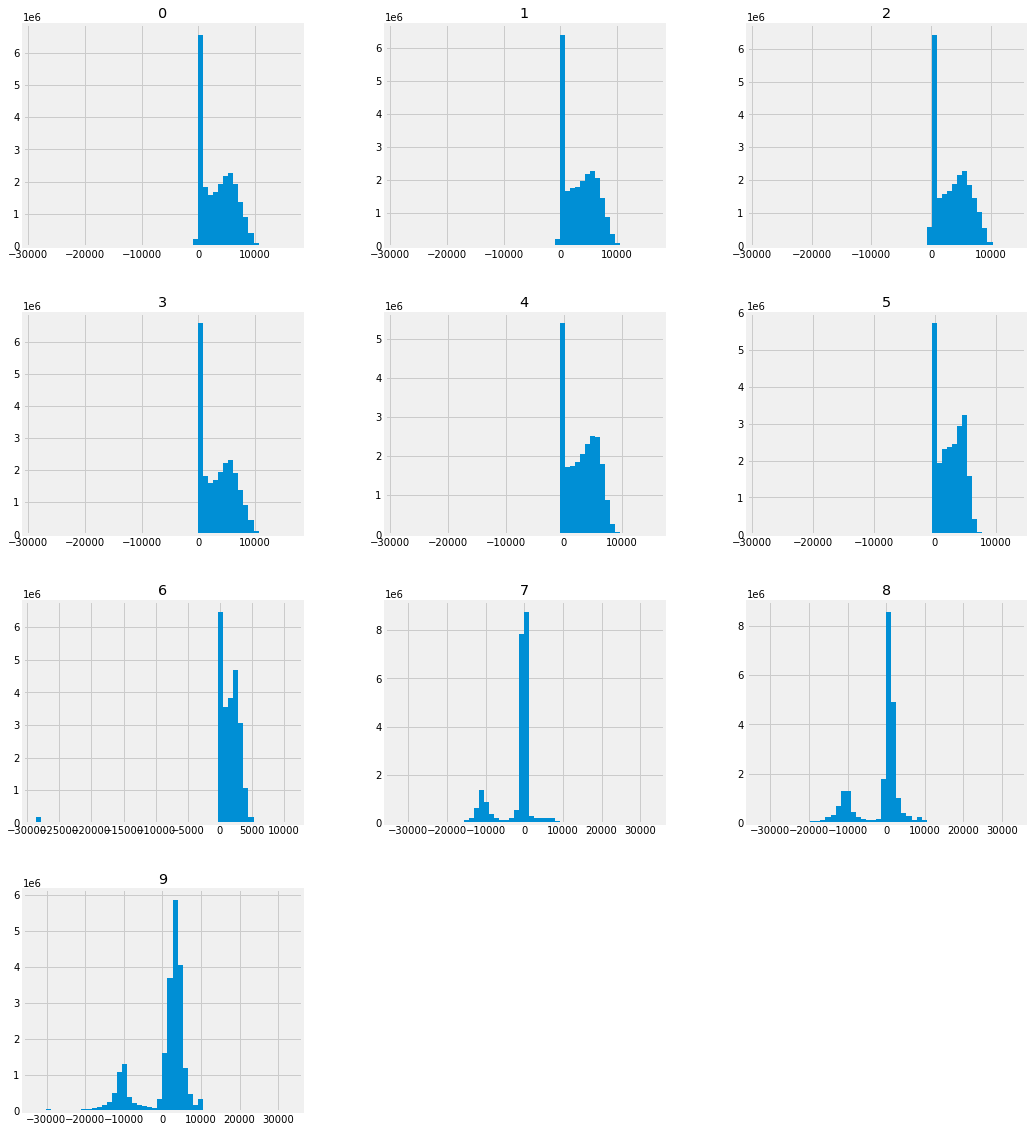

In [24]:
df.hist(figsize=(16, 20), bins=50)

#### Reshape the unravelled matrix back to the 4800x4800 raster shape

In [25]:
shp = (4800, 4800)
matrix = np.asarray(ensemble_predictedRaster)
reshp = matrix.reshape(shp)
reshp.shape

(4800, 4800)

### Import the QA Mask and the Water Mask for the corresponding tile

In [26]:
qaMask = '/att/nobackup/cssprad1/projects/modis_water/data/qa_masks'
waterMask = '/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019'
qa_list = [fn for fn in glob.glob(os.path.join(qaMask, '*A{}{:03}.{}*bad_good_mask.tif'.format(YEAR, DAY, TILE)))]
water_list = [fn for fn in glob.glob(os.path.join(waterMask, '*{}*.tif'.format(TILE)))]
qa_mask = qa_list[0]
water_mask = water_list[0]
print(water_mask)
print(qa_mask)
ds = gdal.Open(qa_mask, gdal.GA_ReadOnly)
waterMask = gdal.Open(water_mask, gdal.GA_ReadOnly)
qaMaskMatrix = ds.GetRasterBand(1).ReadAsArray()
waterMaskMatrix = waterMask.GetRasterBand(1).ReadAsArray()
ds = None
waterMask = None

/att/nobackup/cssprad1/projects/modis_water/data/water_masks/Min2000_2019/MOD44W_h17v02_min2000_2019.tif
/att/nobackup/cssprad1/projects/modis_water/data/qa_masks/MOD09GA.A2006227.h17v02.061.2020269105215_bad_good_mask.tif


In [27]:
waterMaskMatrix

array([[0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

### Mask out results if QA Mask says pixel is "bad"
Mask out water mask if QA Mask says pixel is "bad"

In [28]:
maskedResult = np.where(qaMaskMatrix == 0, reshp, -9999)
maskedResultProba = np.where(qaMaskMatrix == 0, ensemble_probaWater, -9999)
waterMasked = np.where(qaMaskMatrix == 0, waterMaskMatrix, -9999)
waterMaskRavel = waterMasked.ravel()
imWater = (waterMaskRavel == 1)

## Predicted Raster

In [29]:
TILE = 'global_{}_{}'.format(MODEL, TILE)

Text(0.5, 1.0, 'Predicted water mask')

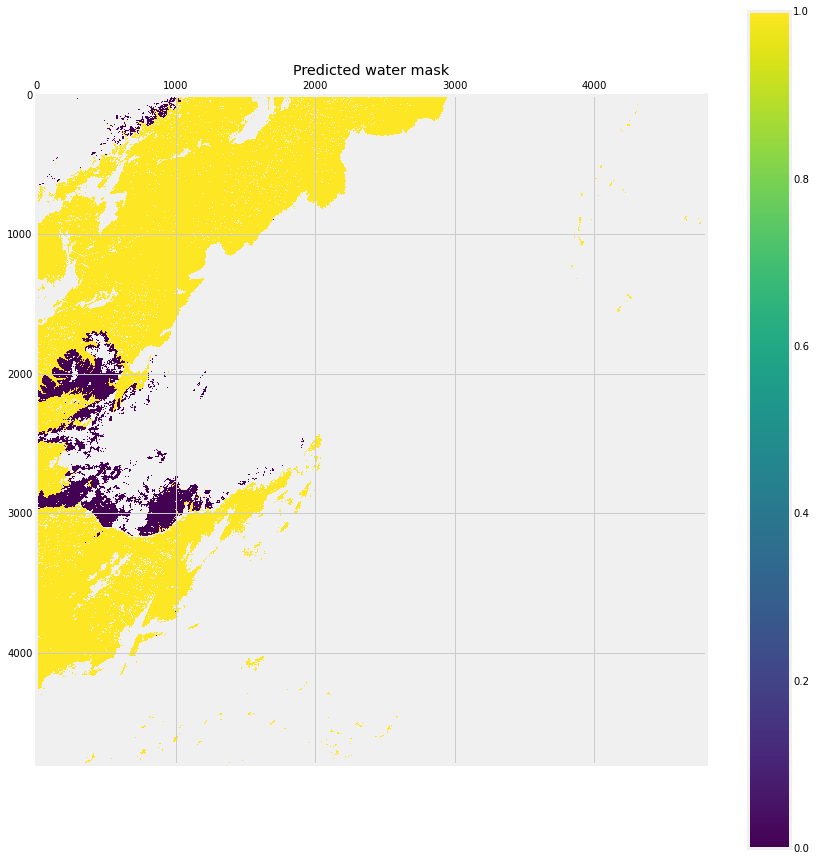

In [30]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResult), fignum=1)
plt.colorbar()
plt.title('Predicted water mask')

## Predicted Probabilities

Text(0.5, 1.0, 'Predicted probabilities of water')

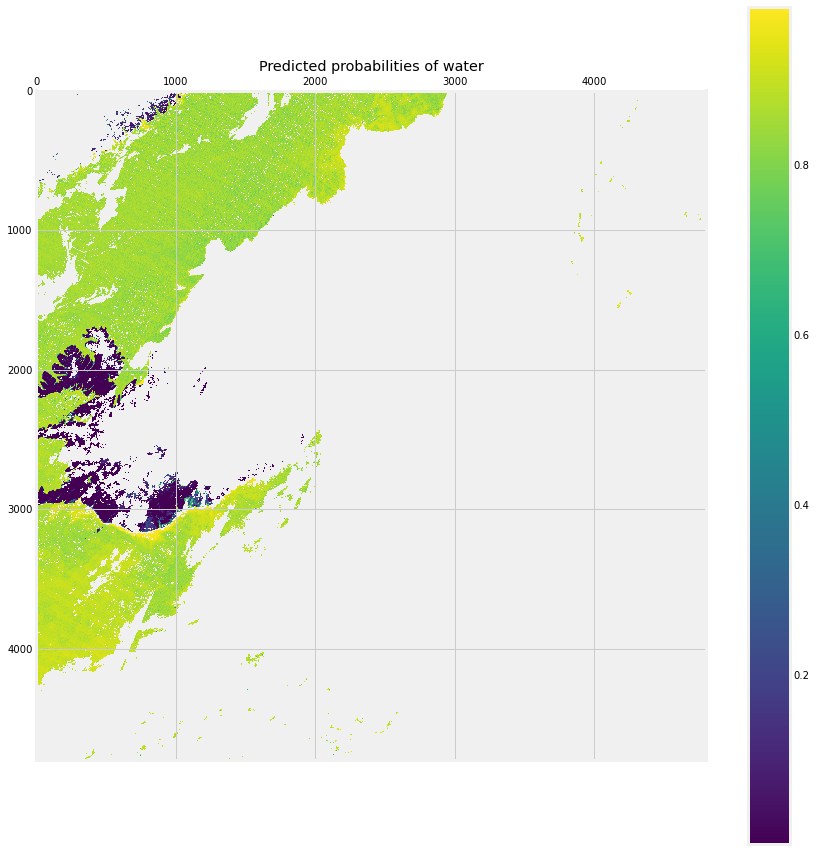

In [31]:
plt.figure(figsize=(15, 15))
outputPlt = plt.matshow(np.where(maskedResult == -9999, np.NaN, maskedResultProba), fignum=1)
plt.colorbar()
plt.title('Predicted probabilities of water')

## Minimum extent water mask

Text(0.5, 1.0, 'Minimum extent water mask')

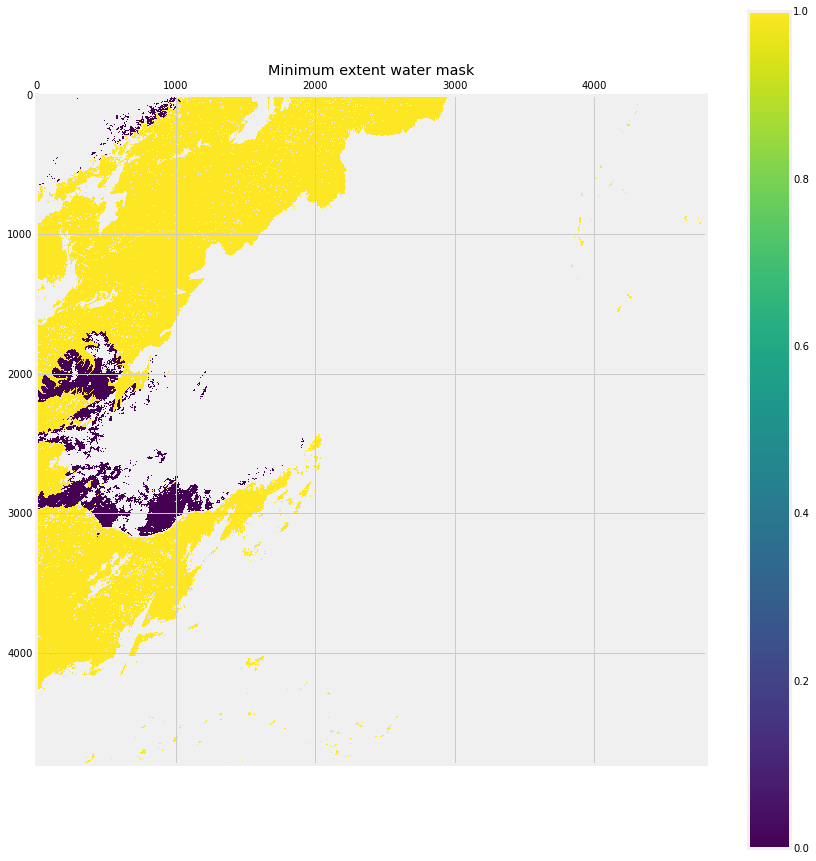

In [32]:
plt.figure(figsize=(15, 15))
truth = np.where(waterMasked==-9999, np.NaN, waterMasked)
truth = np.where(waterMasked==250, np.NaN, truth)
truthPlt = plt.matshow(truth, fignum=1)
plt.colorbar()
plt.title('Minimum extent water mask')

## Metrics on test raster

In [33]:
tp = np.where((waterMasked == 1) & (maskedResult == 1), 1, 0)
tn = np.where((waterMasked == 0) & (maskedResult == 0), 1, 0)
fp = np.where((waterMasked == 0) & (maskedResult == 1), 1, 0)
fn = np.where((waterMasked == 1) & (maskedResult == 0), 1, 0)
total = np.count_nonzero(waterMasked == 1) + np.count_nonzero(waterMasked == 0)
truePositives = np.count_nonzero(tp == 1)
trueNegatives = np.count_nonzero(tn == 1)
falsePositives = np.count_nonzero(fp == 1)
falseNegatives = np.count_nonzero(fn == 1)
accuracy = (truePositives + trueNegatives) / (truePositives + trueNegatives + falsePositives + falseNegatives)
jians = truePositives / (truePositives + trueNegatives)
pc = truePositives / (truePositives + falsePositives)
rc = truePositives / (truePositives + falseNegatives)
f1 = truePositives / (truePositives + (0.5*(falsePositives + falseNegatives)))

### Count num of occurences for each class with the masked predicted result

In [34]:
countNoData = np.count_nonzero(maskedResult == -9999)
countLand = np.count_nonzero(maskedResult == 0)
countWater = np.count_nonzero(maskedResult == 1)
print('Predicted\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoData, countLand, countWater))

Predicted
 Nodata occurences: 18820960
 Land occurance: 450624
 Water occurances: 3768416


### Count num of occurences for each class with the water mask

In [35]:
countNoDataT = np.count_nonzero(waterMasked == -9999)
countLandT = np.count_nonzero(waterMasked == 0)
countWaterT = np.count_nonzero(waterMasked == 1)
print('Truth Vals\n Nodata occurences: {}\n Land occurance: {}\n Water occurances: {}'.format(countNoDataT, countLandT, countWaterT))

Truth Vals
 Nodata occurences: 18820960
 Land occurance: 445016
 Water occurances: 3774024


### Model metrics on raster data

In [36]:
print('Metrics of Accuracy for Raster Test Data')
print('True Positives:  {}'.format(truePositives))
print('True Negatives:  {}'.format(trueNegatives))
print('False Positives: {}'.format(falsePositives))
print('False Negatives: {}'.format(falseNegatives))
print('Total "good" data: {}'.format(total))
print('Accuracy*: {}'.format(accuracy))
print("Jian's metric : {}".format(jians))
print('Precision: {}'.format(pc))
print('Recall: {}'.format(rc))
print('f1: {}'.format(f1))

Metrics of Accuracy for Raster Test Data
True Positives:  3758362
True Negatives:  434962
False Positives: 10054
False Negatives: 15662
Total "good" data: 4219040
Accuracy*: 0.9939047745458682
Jian's metric : 0.8962727421014928
Precision: 0.9973320355289862
Recall: 0.995850052887846
f1: 0.9965904932621273


## Output predicted raster to GeoTiff

In [37]:
outPath = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_{}.tif'.format(YEAR, DAY, TILE, MODEL))
waterMaskForDay = os.path.join(RASTER_OUTPUT_DIR, 'waterMask_{}_qa_{}.tif'.format(YEAR, DAY, TILE, MODEL))
outPathProba = os.path.join(RASTER_OUTPUT_DIR, '{}_{}_{}_predicted_probabilities_{}.tif'.format(YEAR, DAY, TILE, MODEL))
print(outPath)
print(waterMaskForDay)
print(outPathProba)

ds = gdal.Open(vars_list[0], gdal.GA_ReadOnly)
geo = ds.GetGeoTransform()
proj = ds.GetProjection()
ncols = ds.RasterXSize
nrows = ds.RasterYSize
print('Transform')
print(geo)
print('Projection')
print(proj)
print('Width')
print(ncols)
print('Height')
print(nrows)
ds = None

# Output predicted binary raster masked with good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPath, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResult)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output water mask with good-bad masked.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(waterMaskForDay, ncols, nrows, 1, gdal.GDT_Int16, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(waterMasked)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

# Output probabilies raster masked by good-bad mask.
driver = gdal.GetDriverByName('GTiff')
outDs = driver.Create(outPathProba, ncols, nrows, 1, gdal.GDT_Float32, options=['COMPRESS=LZW'])
outDs.SetGeoTransform(geo)
outDs.SetProjection(proj)
outBand = outDs.GetRasterBand(1)
outBand.WriteArray(maskedResultProba)
outBand.SetNoDataValue(-9999)
outDs.FlushCache()
outDs = None
outBand = None
driver = None

/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/2006_227_global_ensemble_pretrained_h17v02_predicted_ensemble_pretrained.tif
/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/waterMask_2006_qa_227.tif
/att/nobackup/cssprad1/projects/modis_water/code/modis_water_random_forest/view/notebook/output/2006_227_global_ensemble_pretrained_h17v02_predicted_probabilities_ensemble_pretrained.tif
Transform
(-1111950.519667, 231.656358, 0.0, 7783653.637667, 0.0, -231.656358)
Projection
PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS